In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
plt.style.use(['science', 'notebook'])
from openpyxl import load_workbook
import imageio

Load spreadsheets

# Question 1

Since 

* $SMR(d, r_d, E) = TMR(d,r_d,E)PSF(r^{(m)}_{d},E)-TMR(d,0,E)$
* $PSF(r^{(m)}_{d},E)= S_p(r^{(m)}_{d},E)PSF(r^{(m)}_0,E)$
* $TMR(d,0,E)=e^{-\mu(d-d_m)}$

where $(m)$ means at the position of maximum dose, and $r_d \approx r_d^{(m)}$, we get

$$SMR(d, r_d, E) = TMR(d,r_d,E)S_p(r_{d},E)PSF(r_0,E)-e^{-\mu(d-d_m)}$$




Get data:

In [2]:
d = np.array([5, 10, 20])
rd = np.array([5, 10, 30])
rd_mesh, d_mesh = np.meshgrid(rd, d)
TMRs = np.array([[0.910,0.745,0.484],
                 [0.928,0.786,0.532],
                 [0.945,0.837,0.620]]).T
Sps = np.array([[0.983,1,1.033]]*3)
mu = 0.043
PSF0 = 1.078
data = TMRs*Sps*PSF0-np.exp(-mu*(d_mesh-1.5))

Print table:

In [3]:
pd.DataFrame(data, columns=[f'SMR(d, {rdi}, 6MV)' for rdi in rd],
                   index=[f'd={di}' for di in d])

,"SMR(d, 5, 6MV)","SMR(d, 10, 6MV)","SMR(d, 30, 6MV)"
d=5,0.104026,0.140106,0.192050
d=10,0.095607,0.153458,0.238212
d=20,0.061527,0.122140,0.239060


# Question 2

## Part A

Given the dimensions of the problem, it is reasonable that a rectangular, $8 \times 15$cm applicator should be used

## Part B

Read in the diagram

In [4]:
im = imageio.imread('a2diagram.png').sum(axis=-1)

Plot and place lines on the diagram. Red lines are used to calibrate units, blue lines give region of rectangle:

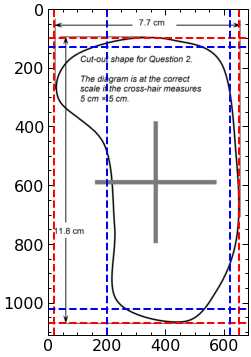

In [5]:
plt.imshow(im, cmap='gray')
plt.axvline(20, color='r', ls='--')
plt.axvline(650, color='r', ls='--')
plt.axhline(100, color='r', ls='--')
plt.axhline(1070, color='r', ls='--')
plt.axvline(200, color='b', ls='--')
plt.axvline(620, color='b', ls='--')
plt.axhline(130, color='b', ls='--')
plt.axhline(1020, color='b', ls='--')
plt.show()

The distance per unit is calculated from the red lines:

In [6]:
d = 11.8/(1070-100)

The area of the recangle is given by the blue lines

In [7]:
a = d*(620-200)
b = d*(1020-130)
print(f'a={a:.2f}')
print(f'b={b:.2f}')

a=5.11
b=10.83


The approximate equivalent square field is thus

In [8]:
rd = 2*a*b/(a+b)
rd

6.942378216730937

Or about $7 \times 7$cm.

## Part C

The attenuation coefficient is given by

$\mu = \rho \cdot (\mu/\rho)$

where $\rho=11.35$g/cm$^3$ and $\mu/\rho$ is interpolated from the table:

In [9]:
x1 = 2e-1
x2 = 3e-1
y1 = 9.985e-1
y2 = 4.035e-1
m = (y2-y1)/(x2-x1)
mu_rho = y1+m*(2.5e-1 - x1)
mu = mu_rho*11.35

Give that $I/I_0 = e^{-\mu x}$  we have

$$x = -\frac{1}{\mu} \cdot \ln(I/I_0) $$

In [10]:
x = -(1/mu)*np.log(0.03)
print(f'Thickness of Lead Required: {x:.3f}cm')

Thickness of Lead Required: 0.441cm


# Question 3

## Part A

The rate at which the dose is administered is given by

$$D' = D_0' S_c(r_c, E)S_p(r,E) = S_{c,p}(r_c,r_0,E) \cdot \frac{S_p(r)}{S_p(r_0)} $$

* $D_0'=61$cGy/min
* $r_c=6 \times 10$cm
* $r_0=7.5$cm (uniquely obtained from $r_c$)
* $r=6.5$cm (specified by lead cut-out)

The time is then given by

$$t = D/D'$$

where $D=250$cGy

In [11]:
D = 250
D0p = 61.7
Scp = 0.957
Sp_r = 0.948
Sp_r0 = 0.965
Dp = D0p*Scp*Sp_r/Sp_r0
t = D/Dp
print(f'Time Required: {t:.2f}min')

Time Required: 4.31min


## Part B

We know that

$D(d) = D(0) \cdot P(r, d, E)$

where $P$ is percent depth dose. So we want to find $d$ such that

$P(6.5,d,E) = \frac{100}{250} = 0.4$

which, through trial and error in the excel spread sheet occurs at approximately $\boxed{d=8\text{cm}}$

## Part C

In this case, we need to correct using the inverse square law

$$D' = S_{c,p}(r_c,r_0,E) \cdot \frac{S_p(r)}{S_p(r_0)}\left(\frac{SSD_0}{SSD}\right)^2 $$

(**note**: the field size at the surface is the exact same, the same, the only difference is that it is less intense due to the increased distance away of the scanner)

In [12]:
Dp*=(50/52.5)**2
t = D/Dp
print(f'Time Required: {t:.2f}min')

Time Required: 4.75min


# Question 4

## Part A

Noting that 

$$SAR(d,r_d,E) = TMR(d,r_d,E)PSF(r_d,E) - TMR(d_m,0,E) = PSF(r_d,E) - 1$$

at $d=d_m$ (since $TMR(d_m,r_d,E)=1$), we need to compute $PSF$s for different values of $r_d$. These values are related to the three intersections we need to consider:

<p align="center">
  <img src="images/a2p2.png" alt="drawing" width="600" align="center"/>
</p>

It is clear that

* $R_1=3.5$cm
* $R_2=4.5$cm

$R_3$ can be calculated as follows. The height of point $A$ is $6.5/2 + 0.45$cm $=3.7$cm. This is the same as the height on the right triangle. Since $x/y$ is constant along the slope of the right triangle, the $x$ location along the triangle is $x_2 = 3.7 \cdot 6.3/4.8 =4.85625$cm or $6.3-4.85625 = 1.44375$cm from the right of the field. Thus $R_3 = 4.5 + 10.5 - 1.44375 = 13.55625$cm

* $R_3=13.55625$cm

**Computing PSF**:

Since $PSF(10,E)=1.078$ (lecture 3 page 34), the formula $PSF(r_d,E)=S_p(r_d,E)PSF(10,E)$ can be used to compute individual PSFs for $R_1$, $R_2$, and $R_3$. Note that $r_i = \sqrt{\pi}R_i$

In [13]:
r1 = np.sqrt(np.pi)*3.5
r2 = np.sqrt(np.pi)*4.5
r3 = np.sqrt(np.pi)*13.55625
print(r1)
print(r2)
print(r3)

6.203588478169306
7.976042329074821
24.0278275163379


These can be used to find the Sp's and thus the PSFs for each of the R's.

In [14]:
Sp1 = 0.987714
Sp2 = 0.993916
Sp3 = 1.027833393
PSF0 = 1.078
PSF1, PSF2, PSF3 = PSF0*np.array([Sp1,Sp2,Sp3])

The total PSF is given by

In [15]:
PSF = PSF1 - PSF2 + PSF3 
print(f'The PSF of segment 1 is {PSF:.3f}')

The PSF of segment 1 is 1.101


The SAR is given by

In [16]:
SAR = (PSF1-1)-(PSF2-1)+(PSF3-1)
print(f'The SAR of segment 1 is {SAR:.3f}')

The SAR of segment 1 is 0.101


## Part B

Since $PSF(r_d,E)=S_p(r_d,E)PSF(10,E)$, we are looking for the value of $r_d$ that makes $S_p = 1.069/1.078=0.99165$.From the interpolation sheet, this occurs precisely when $r_d = 7.3285$ 

The area of the unshaded regions is given by

In [17]:
A = 21*6.5 - 2*(0.5*4.8*6.3)-2*6.5
A

93.26

This area is much larger than the area of the equivalent square:

In [18]:
7.3285**2

53.70691225

This discrepancy is due to the fact that Clarkson integration takes into account the effects of scatter: since the area of the unshaded regions is spread out throughout the image (blocked by shielding in various regions), less scatter contribution occurs than if the area were all confined to a single, fully-connected region. In addition, point A is located off the CAX and thus has less scatter contribution (which corresponds to a smaller equivalent square area).

## Part C

# Question 5

Before beginning, we will need to find $d_A$ and $d_C$ on the diagram below

<p align="center">
  <img src="images/a2p3.png" alt="drawing" width="600" align="center"/>
</p>

For $d_A$, note that

$$\tan(22^{\circ}) = \frac{4.5-d_A}{2.7}$$

Solving for $d_A$ yields

In [19]:
dA = 4.5-2.7*np.tan(22*2*np.pi/360)
dA

3.4091291902450767

For $d_C$, we have

$$\tan(22^{\circ}) = \frac{d_C-4.5}{2.7}$$

In [20]:
dC = 4.5+2.7*np.tan(22*2*np.pi/360)
dC

5.590870809754923

## Part A

### Part (i)

This whole problem is made quite simple when noting that

$$D \propto TMR \cdot OAR \cdot S_p \cdot SPD^{-2}$$

* $TMR$ takes into account how much phantom is above the dose point (takes into account slanting surfaces at the top)
* $OAR$ takes into account the distance from the central axis (distance $x$ used is hoz distance between ray and isocenter)
* $S_p$ takes into account scatter effects
* Inverse square law takes into account decreased beam intensity

This is summaried by the diagram:

<p align="center">
  <img src="images/a2p4.png" alt="drawing" width="600" align="center"/>
</p>

Furthermore, by definition, $TMR=OAR$ at $d_m$ along the CAX at the isocenter (dose point $D_N$).

Thus

$$D_i = D_N\cdot TMR(d_i, r_i) \cdot OAR(d_i,x_i)\frac{S_p(r_i)}{S_p(r_{d_N})}\left(\frac{SAD}{SSD_i+d_i}\right)^2$$

To obtain $D_N$, note that

$$\frac{D_E}{D_N} = TMR(d_E, r_{d_E}) \frac{S_p(r_{d_E})}{S_p(r_{d_N})}\left(\frac{SAD}{SAD+d_E}\right)^2$$

since the SSD is the SAD for $E$. 

In [21]:
SAD = 100
dE = 6+3+2
rdN = 12
rdE = 12*(SAD+dE)/SAD
print(dE)
print(rdE)

11
13.32


These can be used to get TMRs and Sps

In [22]:
TMR = 0.773
Sp_rdE = 1.008632
Sp_rdN = 1.0052

Then DN can be obtained

In [23]:
DE = 100
DN = DE/(TMR*Sp_rdE/Sp_rdN * (SAD/(SAD+dE))**2)
DN

158.8496276082758

Now all the other quantities can be obtained to get the other doses (in order: A, B, C, D, F). For the off axis distances, we choose the coordinate system such that positive $x$ is towards the thick side of the wedge (to the left)

In [24]:
order = ['A', 'B', 'C', 'D', 'F']
ds = [dA,
      4.5,
      dC,
      dA+1.5+3+2,
      dC+1.5+3+2]
rds = 3*[12*(SAD+4.5)/SAD] + 2*[12*(SAD+dE)/SAD]
xs = [2.7, 0, -2.7, 2.7, -2.7]
SPDs = 3*[SAD+4.5] + 2*[SAD+dE]
[print(f'{o}: d={d:.2f}, rd={rd:.3f}, x={x:.2f}') \
     for (o, d, rd, x) in zip(order, ds, rds, xs)];

A: d=3.41, rd=12.540, x=2.70
B: d=4.50, rd=12.540, x=0.00
C: d=5.59, rd=12.540, x=-2.70
D: d=9.91, rd=13.320, x=2.70
F: d=12.09, rd=13.320, x=-2.70


These can be used to get TMRS and Sp's

In [25]:
TMRs = [0.970, 0.944, 0.916, 0.803, 0.744]
Sps = 3*[1.006604] + 3*[1.008632]
OARs = [1.014, 1, 1.013, 1.011, 1.010]
[print(f'{o}: TMR={TMR:.5f}, Sp={Sp:.5f}, OAR={OAR:.5f}') \
     for (o, TMR, Sp, OAR) in zip(order, TMRs, Sps, OARs)];

A: TMR=0.97000, Sp=1.00660, OAR=1.01400
B: TMR=0.94400, Sp=1.00660, OAR=1.00000
C: TMR=0.91600, Sp=1.00660, OAR=1.01300
D: TMR=0.80300, Sp=1.00863, OAR=1.01100
F: TMR=0.74400, Sp=1.00863, OAR=1.01000


Then we can compute Doses

In [26]:
def compute_dose(DN, TMR, Sp, SPD, OAR):
    return DN*TMR*OAR*(Sp/Sp_rdN)*(SAD/SPD)**2

doses = [compute_dose(DN, TMRi, Spi, SPDi, OARi) \
         for (TMRi, Spi, SPDi, OARi) in zip(TMRs, Sps, SPDs, OARs)]
[print(f'{o}: D={D:.2f}Gy') for (o, D) in zip(order, doses)];

A: D=143.27Gy
B: D=137.51Gy
C: D=135.17Gy
D: D=105.02Gy
F: D=97.21Gy


### Part (ii)

The only thing that changes here is the OARs

In [27]:
OARs = [0.940, 1, 1.078, 0.941, 1.075]
doses = [compute_dose(DN, TMRi, Spi, SPDi, OARi) \
         for (TMRi, Spi, SPDi, OARi) in zip(TMRs, Sps, SPDs, OARs)]
[print(f'{o}: D={D:.2f}Gy') for (o, D) in zip(order, doses)];

A: D=132.82Gy
B: D=137.51Gy
C: D=143.84Gy
D: D=97.75Gy
F: D=103.47Gy


Note that $F$ gets more dose, but this is because the beam is still prescribed to give 100Gy to point E (and since part of the wedge is in the way, it means the beam is either more intense/runs for longer).

## Part B

### Part (i)

Since $E$ recieves 100Gy, we first need to use this to find $D_N$, which we can eventually use to find all other doses. First lets find the effective distances for points D, E, and F

In [28]:
rhos = np.array([1,0.4,1])
ds_D = np.array([dA+1.5, 3, 2])
ds_E = np.array([6, 3, 2])
ds_F = np.array([dC+1.5, 3, 2])

Get effective distance

In [39]:
deff_D = np.dot(rhos, ds_D)
deff_E = np.dot(rhos, ds_E)
deff_F = np.dot(rhos, ds_F)
[print(f'Effective Distance to {l}: {d:.2f}') \
 for (l, d) in zip(['D', 'E', 'F'],[deff_D, deff_E, deff_F])];

Effective Distance to D: 8.11
Effective Distance to E: 9.20
Effective Distance to F: 10.29


Now point E is still prescribed to receive 100Gy; this can be used to recalculate $D_N$. We need the TMR that corresponds to the effective distance of $E$ above

In [41]:
DE = 100
TMR = 0.821
DN = DE/(TMR*Sp_rdE/Sp_rdN * (SAD/(SAD+dE))**2)
print(f'DN={DN:.3f}Gy')

DN=149.562Gy


Now we can recompute the dose to the other points, provided we reevaluate the TMR values. The only TMRs that change are those for D and F. Lets bring back up the values of $r_d$ for all the different points (A,B,C,D,F):

In [43]:
print(rds)

[12.54, 12.54, 12.54, 13.32, 13.32]


These, along with the effective distances above to (D, E, F) and the actual distances to (A,C), can be used to calculate TMRs from the table

In [44]:
TMRs = [0.970, 0.944, 0.916, 0.851, 0.793]

Now lets recompute all the doses:

In [47]:
OARs = [1.014, 1, 1.013, 1.011, 1.010]
doses = [compute_dose(DN, TMRi, Spi, SPDi, OARi) \
         for (TMRi, Spi, SPDi, OARi) in zip(TMRs, Sps, SPDs, OARs)]
[print(f'{o}: D={D:.2f}Gy') for (o, D) in zip(order, doses)];

A: D=134.90Gy
B: D=129.47Gy
C: D=127.26Gy
D: D=104.79Gy
F: D=97.56Gy


### Part (ii)

The only thing that changes is the OARs, which are the same as in part A with the dynamic wedge:

In [48]:
OARs = [0.940, 1, 1.078, 0.941, 1.075]
doses = [compute_dose(DN, TMRi, Spi, SPDi, OARi) \
         for (TMRi, Spi, SPDi, OARi) in zip(TMRs, Sps, SPDs, OARs)]
[print(f'{o}: D={D:.2f}Gy') for (o, D) in zip(order, doses)];

A: D=125.05Gy
B: D=129.47Gy
C: D=135.43Gy
D: D=97.54Gy
F: D=103.83Gy


## Part C

**Without the homogeneity:**

In [50]:
DE = 100
TMR = 0.773
DN = DE/(TMR*Sp_rdE/Sp_rdN * (SAD/(SAD+dE))**2)
DN

158.8496276082758

So 100cGy at point $E$ means 158.8cGy at the normalization depth, where 1cGy/MU is delivered. It follows that 158.8 monitor units are required.

**With the homogenity**

In [52]:
DE = 100
TMR = 0.821
DN = DE/(TMR*Sp_rdE/Sp_rdN * (SAD/(SAD+dE))**2)
DN

149.56243866162873

Similar to the argument above, 149.56 monitor units are required. This is less than above and this makes sense; since less attenuation occurs in the medium, more of the beam is left to deliver dose at point E.

# Question 6

## Part A

We can write

$$\frac{D_E^{*}}{D_N} = TMR(d_E, r_{d_E})$$

where $D_E^*$ is the corrected dose using

$$D_E^* = CF \cdot D_E = \left( \frac{TMR(3+2, r_{d_E})}{TMR(2, r_{d_E})} \right)^{0.4-1} D_E$$

Thus 

$$D_N = \frac{1}{TMR(d_E, r_{d_E})} \left( \frac{TMR(3+2, r_{d_E})}{TMR(2, r_{d_E})} \right)^{0.4-1} D_E $$ 

where $D_E=100$cGy and $r_{d_E}=12$ and $d_E=11$

In [54]:
TMR_dE = 0.767
TMR_5 = 0.929
TMR_2 = 0.998
DN = 1/TMR_dE * (TMR_5/TMR_2)**(-0.6) * 100 
print(f'DN={DN:.3f}Gy')

DN=136.105Gy
